In [145]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thepbordin/indoor-object-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'indoor-object-detection' dataset.
Path to dataset files: /kaggle/input/indoor-object-detection


In [146]:
!pip install ultralytics --upgrade

In [147]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2
import torch
from pathlib import Path
import sys
import kagglehub
import shutil
from collections import Counter
import matplotlib.patches as patches

from ultralytics import YOLO

%matplotlib inline


In [148]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name())
else:
    print("⚠️ GPU is NOT active! Go to Runtime → Change runtime type → GPU")


CUDA available: True
GPU name: Tesla T4


In [149]:
# Downloading the dataset via kagglehub
ds_path = Path(path)   

print("Dataset root:", ds_path)

print("Contents of dataset root:", list(ds_path.iterdir()))

Dataset root: /kaggle/input/indoor-object-detection
Contents of dataset root: [PosixPath('/kaggle/input/indoor-object-detection/data.yaml'), PosixPath('/kaggle/input/indoor-object-detection/valid'), PosixPath('/kaggle/input/indoor-object-detection/test'), PosixPath('/kaggle/input/indoor-object-detection/train')]


In [150]:
print(list((ds_path/'train').iterdir()), '\n')
print(list((ds_path/'valid').iterdir()), '\n')
print(list((ds_path/'test').iterdir()))

[PosixPath('/kaggle/input/indoor-object-detection/train/labels'), PosixPath('/kaggle/input/indoor-object-detection/train/images')] 

[PosixPath('/kaggle/input/indoor-object-detection/valid/labels'), PosixPath('/kaggle/input/indoor-object-detection/valid/images')] 

[PosixPath('/kaggle/input/indoor-object-detection/test/labels'), PosixPath('/kaggle/input/indoor-object-detection/test/images')]


In [151]:
train_dir = ds_path /  "train"
val_dir   = ds_path / "valid"
test_dir  = ds_path / "test"  

In [152]:
print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Train exists:", train_dir.exists())
print("Val exists:", val_dir.exists())

Train dir: /kaggle/input/indoor-object-detection/train
Val dir: /kaggle/input/indoor-object-detection/valid
Train exists: True
Val exists: True


In [153]:
def folder_report(folder: Path, max_examples: int = 5):
    files = [p for p in folder.iterdir() if p.is_file()]
    ext_counts = Counter(p.suffix.lower() for p in files)
    print(f"\n📁 {folder}")
    print(f"  Total files: {len(files)}")
    print("  Extensions:", dict(sorted(ext_counts.items(), key=lambda x: (-x[1], x[0]))))
    if files:
        examples = sorted(files)[:max_examples]
        print("  Examples:")
        for p in examples:
            print("   -", p.name)

def split_report(split_dir: Path):
    print(f"Split: {split_dir.name}")
    print(f"Root: {split_dir}")

    # Якщо раптом структура інша — покажемо root теж
    folder_report(split_dir, max_examples=10)

    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"

    if images_dir.exists():
        folder_report(images_dir)
    else:
        print(f"\n⚠️ No images folder: {images_dir}")

    if labels_dir.exists():
        folder_report(labels_dir)
    else:
        print(f"\n⚠️ No labels folder: {labels_dir}")

In [154]:
split_report(train_dir)
# split_report(val_dir)
# split_report(test_dir)

Split: train
Root: /kaggle/input/indoor-object-detection/train

📁 /kaggle/input/indoor-object-detection/train
  Total files: 0
  Extensions: {}

📁 /kaggle/input/indoor-object-detection/train/images
  Total files: 1012
  Extensions: {'.jpg': 974, '.png': 27, '.jpeg': 11}
  Examples:
   - 0001cb734adac2ee.jpg
   - 000bf0ddff4c7310.jpg
   - 000c052bb4b882c4.jpg
   - 000c66e044e850f7.jpg
   - 000c9e454bbf6d0d.jpg

📁 /kaggle/input/indoor-object-detection/train/labels
  Total files: 1008
  Extensions: {'.txt': 1008}
  Examples:
   - 0001cb734adac2ee.txt
   - 000bf0ddff4c7310.txt
   - 000c052bb4b882c4.txt
   - 000c66e044e850f7.txt
   - 000c9e454bbf6d0d.txt


In [155]:
IMG_EXTS = {".jpg", ".jpeg", ".png"}

def find_mismatches(split_dir: Path):
    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"

    image_files = [p for p in images_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    label_files = [p for p in labels_dir.iterdir() if p.is_file() and p.suffix.lower() == ".txt"]

    image_stems = {p.stem for p in image_files}
    label_stems = {p.stem for p in label_files}

    images_without_labels = sorted(image_stems - label_stems)
    labels_without_images = sorted(label_stems - image_stems)

    return images_without_labels, labels_without_images

for sd in [train_dir, val_dir, test_dir]:
    i_wo_l, l_wo_i = find_mismatches(sd)
    print(f"\n=== {sd.name} ===")
    print("images without labels:", len(i_wo_l), i_wo_l[:20])
    print("labels without images:", len(l_wo_i), l_wo_i[:20])


=== train ===
images without labels: 4 ['23e9876d80301685', '506bd74062053978', '62fbb8ea21b31940', 'acafde3057686f65']
labels without images: 0 []

=== valid ===
images without labels: 0 []
labels without images: 0 []

=== test ===
images without labels: 3 ['1139', '1167', '831']
labels without images: 0 []


In [156]:
print("CWD:", os.getcwd())
print("Writable /content exists:", os.path.exists("/content"))
print("Writable /kaggle/working exists:", os.path.exists("/kaggle/working"))

CWD: /content
Writable /content exists: True
Writable /kaggle/working exists: False


In [157]:
src_root = ds_path  #поточний шлях з kagglehub cache або змонтований input
dst_root = Path("/content/indoor-object-detection")

if not dst_root.exists():
    shutil.copytree(src_root, dst_root)
    print("Copied dataset to:", dst_root)
else:
    print("Dataset already exists:", dst_root)

# Оновлюємо шляхи на копію
ds_path   = dst_root
train_dir = ds_path / "train"
val_dir   = ds_path / "valid"
test_dir  = ds_path / "test"

Dataset already exists: /content/indoor-object-detection


In [158]:
missing_train_imgs, missing_train_lbls = find_mismatches(train_dir)
missing_test_imgs,  missing_test_lbls  = find_mismatches(test_dir)

print("train images without labels:", missing_train_imgs)
print("train labels without images:", missing_train_lbls)
print("test  images without labels:", missing_test_imgs)
print("test  labels without images:", missing_test_lbls)

train images without labels: []
train labels without images: []
test  images without labels: []
test  labels without images: []


In [159]:
def create_empty_labels(split_dir: Path, stems):
    labels_dir = split_dir / "labels"
    created = []
    for s in stems:
        fp = labels_dir / f"{s}.txt"
        if not fp.exists():
            fp.write_text("")
            created.append(fp.name)
    return created

print("Created train:", create_empty_labels(train_dir, missing_train_imgs))
print("Created test :", create_empty_labels(test_dir,  missing_test_imgs))

Created train: []
Created test : []


In [160]:
for sd in [train_dir, val_dir, test_dir]:
    i_wo_l, l_wo_i = find_mismatches(sd)
    print(sd.name, "images without labels:", len(i_wo_l), "labels without images:", len(l_wo_i))

train images without labels: 0 labels without images: 0
valid images without labels: 0 labels without images: 0
test images without labels: 0 labels without images: 0


In [161]:
print((ds_path / "data.yaml").read_text())

train: /content/data/train/images
val: /content/data/valid/images
test: /content/data/test/images
nc: 10
names: 
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole


In [162]:
indoor_yaml = ds_path / "indoor.yaml"

data_cfg = {
    "path": str(ds_path),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": 10,
    "names": ["door", "cabinetDoor", "refrigeratorDoor", "window", "chair",
              "table", "cabinet", "couch", "openedDoor", "pole"]
}

import yaml
with open(indoor_yaml, "w") as f:
    yaml.safe_dump(data_cfg, f, sort_keys=False, allow_unicode=True)

print("Saved:", indoor_yaml)
print(indoor_yaml.read_text())

Saved: /content/indoor-object-detection/indoor.yaml
path: /content/indoor-object-detection
train: train/images
val: valid/images
test: test/images
nc: 10
names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole



In [163]:
class Indoor:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0 # Specifies the fraction of the dataset to use for training. Allows for training on a subset of the full dataset, useful for experiments or when resources are limited.
    SEED = 42

    # classes
    CLASSES = ["door", "cabinetDoor", "refrigeratorDoor", "window", "chair",
              "table", "cabinet", "couch", "openedDoor", "pole"]
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 30 # 100
    BATCH_SIZE = 8 # 16
    
    BASE_MODEL = 'yolov9m' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'indoor_{BASE_MODEL}_{EPOCHS}e'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01 # Final learning rate as a fraction of the initial rate = (lr0 * lrf), used in conjunction with schedulers to adjust the learning rate over time.
    WEIGHT_DECAY = 5e-4 # L2 regularization term, penalizing large weights to prevent overfitting.
    DROPOUT = 0.0 
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    DATA_YAML = (ds_path / "indoor.yaml").as_posix()

    # # paths
    # CUSTOM_DATASET_DIR = (ds_path).as_posix() + "/"
    # OUTPUT_DIR = './'


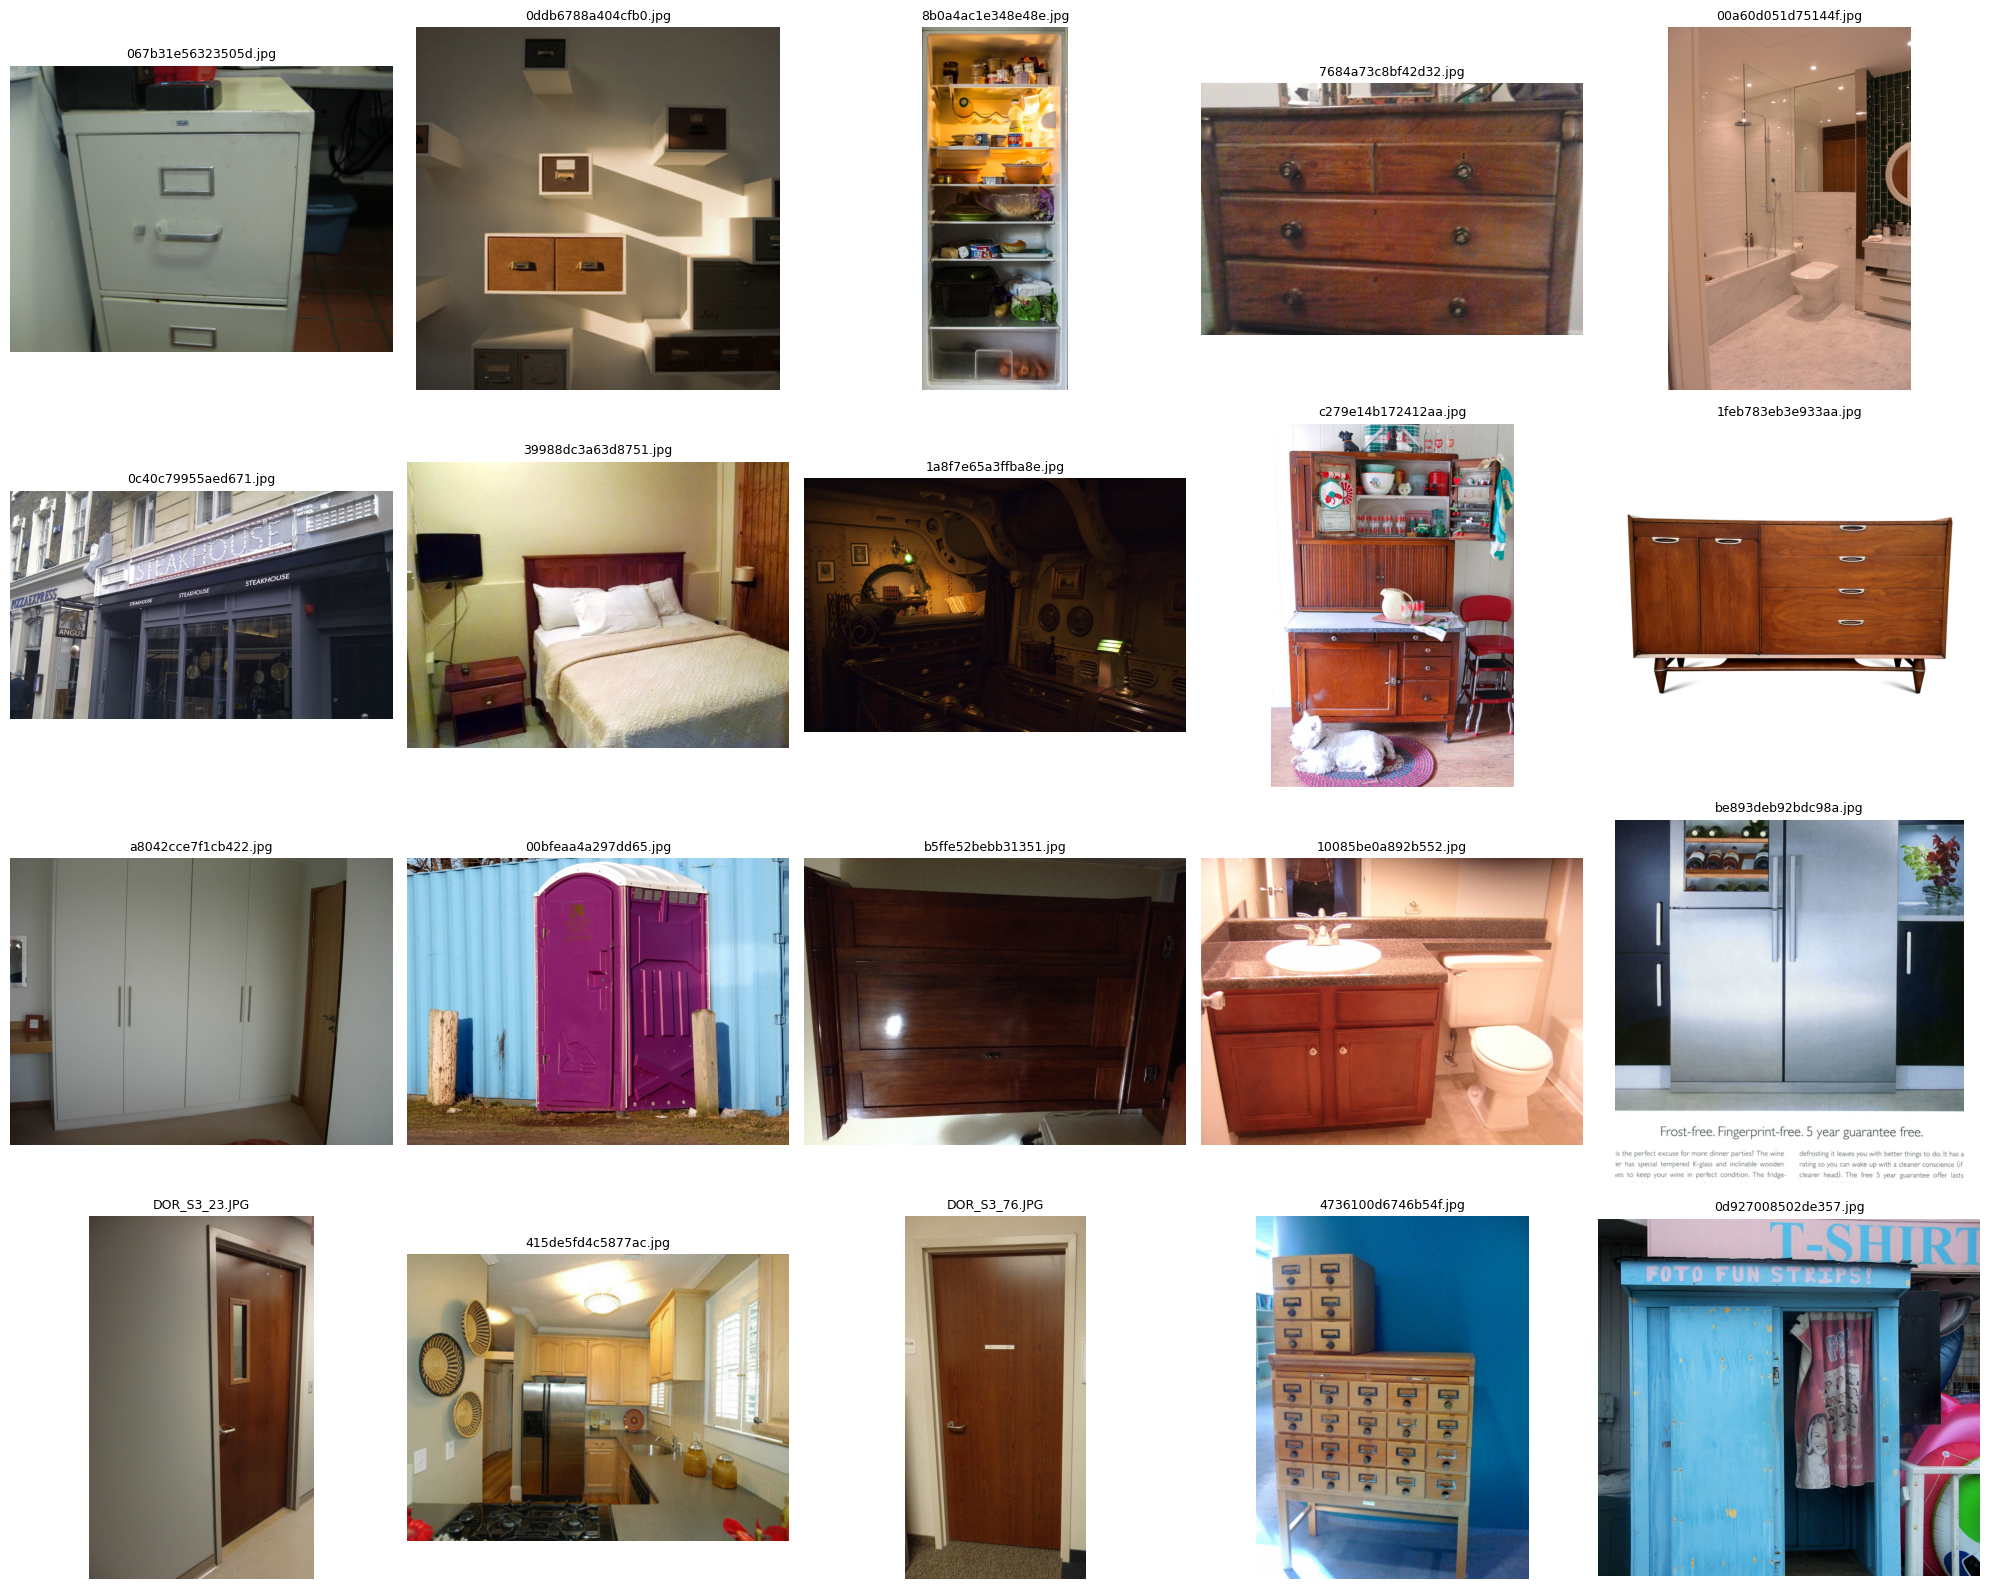

In [164]:
split_dir = train_dir  #val_dir / test_dir
images_dir = split_dir / "images"

IMG_EXTS = {".jpg", ".jpeg", ".png"}
N = 20

img_files = [p for p in images_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
sample = random.sample(img_files, k=min(N, len(img_files)))

cols = 5
rows = (len(sample) + cols - 1) // cols

plt.figure(figsize=(cols*4, rows*4))
for i, p in enumerate(sample, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(Image.open(p).convert("RGB"))
    plt.title(p.name, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

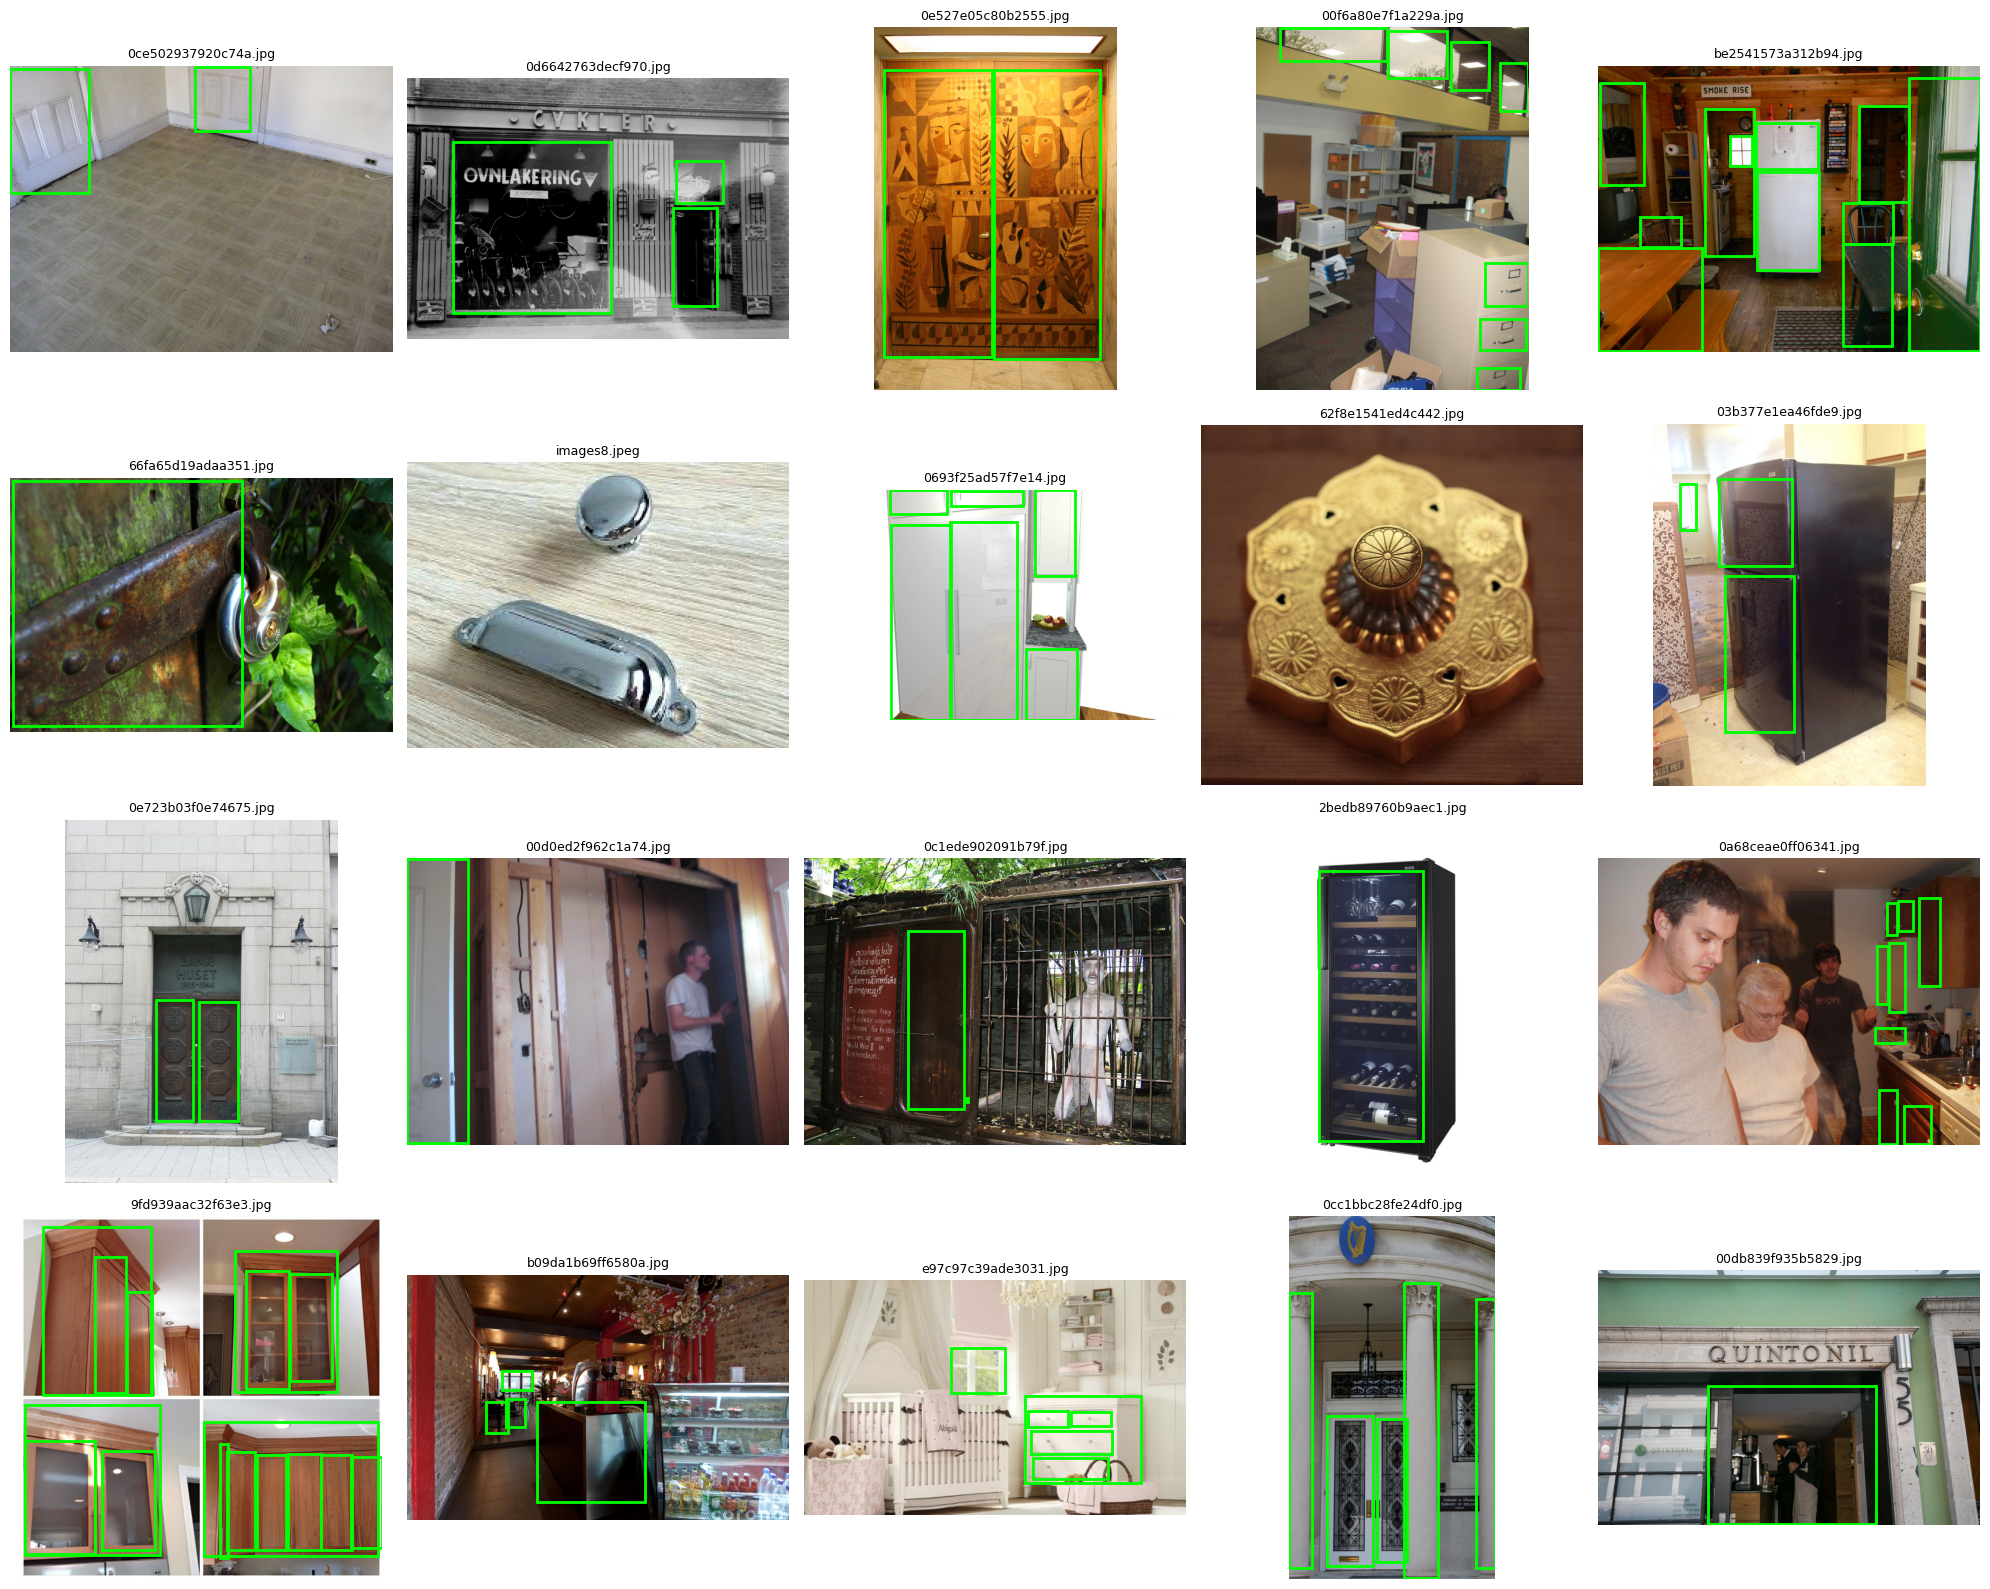

In [165]:
split_dir = train_dir  # або val_dir / test_dir
images_dir = split_dir / "images"
labels_dir = split_dir / "labels"

IMG_EXTS = {".jpg", ".jpeg", ".png"}
N = 20

def read_yolo_labels(label_path: Path):
    rows = []
    if not label_path.exists():
        return rows
    txt = label_path.read_text().strip()
    if not txt:
        return rows
    for line in txt.splitlines():
        parts = line.split()
        if len(parts) != 5:
            continue
        cls = int(parts[0])
        xc, yc, w, h = map(float, parts[1:])
        rows.append((cls, xc, yc, w, h))
    return rows

img_files = [p for p in images_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
sample = random.sample(img_files, k=min(N, len(img_files)))

cols = 5
rows = (len(sample) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten() if rows*cols > 1 else [axes]

for ax in axes[len(sample):]:
    ax.axis("off")

for i, img_path in enumerate(sample):
    ax = axes[i]
    ax.axis("off")

    img = Image.open(img_path).convert("RGB")
    W, H = img.size
    ax.imshow(img)
    ax.set_title(img_path.name, fontsize=9)

    label_path = labels_dir / f"{img_path.stem}.txt"
    labels = read_yolo_labels(label_path)

    for (c, xc, yc, w, h) in labels:
        x1 = (xc - w/2) * W
        y1 = (yc - h/2) * H
        bw = w * W
        bh = h * H
        rect = patches.Rectangle((x1, y1), bw, bh, linewidth=2, edgecolor="lime", facecolor="none")
        ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [166]:
for p in sample[:3]:
    img = Image.open(p)
    print(p.name, img.size, img.mode)

0ce502937920c74a.jpg (1024, 768) RGB
0d6642763decf970.jpg (1024, 700) L
0e527e05c80b2555.jpg (683, 1024) RGB


In [167]:
class_idx = {str(i): Indoor.CLASSES[i] for i in range(Indoor.NUM_CLASSES_TO_TRAIN)}

class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {Indoor.CLASSES[i]: 0 for i in range(Indoor.NUM_CLASSES_TO_TRAIN)}

    labels_path = Path(ds_path) / mode / "labels"   # <-- головна заміна

    for file in labels_path.glob("*.txt"):
        for line in file.read_text().splitlines():
            parts = line.split()
            if len(parts) != 5:
                continue
            cls = parts[0]  # '0'..'9'
            class_count[class_idx[cls]] += 1   # +1 за кожен bbox

    data_volume = len(list(labels_path.glob("*.txt")))
    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_volume})

dataset_stats_df = pd.DataFrame(class_info)
display(dataset_stats_df)

Mode  door  cabinetDoor  refrigeratorDoor  window  chair  table  cabinet  \
0  train   479         3178               689     403    204    228      179   
1  valid    97          765               192      91     49     40       32   
2   test    34          179                 2      63     87     47       52   

   couch  openedDoor  pole  Data_Volume  
0     27          78    27         1012  
1      1          13     9          230  
2     58          20     8          107

Аналіз кількості об’єктів (bbox) у розмітці показав суттєвий дисбаланс класів: клас cabinetDoor представлений значно частіше за інші, тоді як класи couch та pole мають дуже малу кількість прикладів. Це може призводити до нижчих значень precision/recall та mAP для рідкісних класів і до більшої кількості міжкласових помилок.

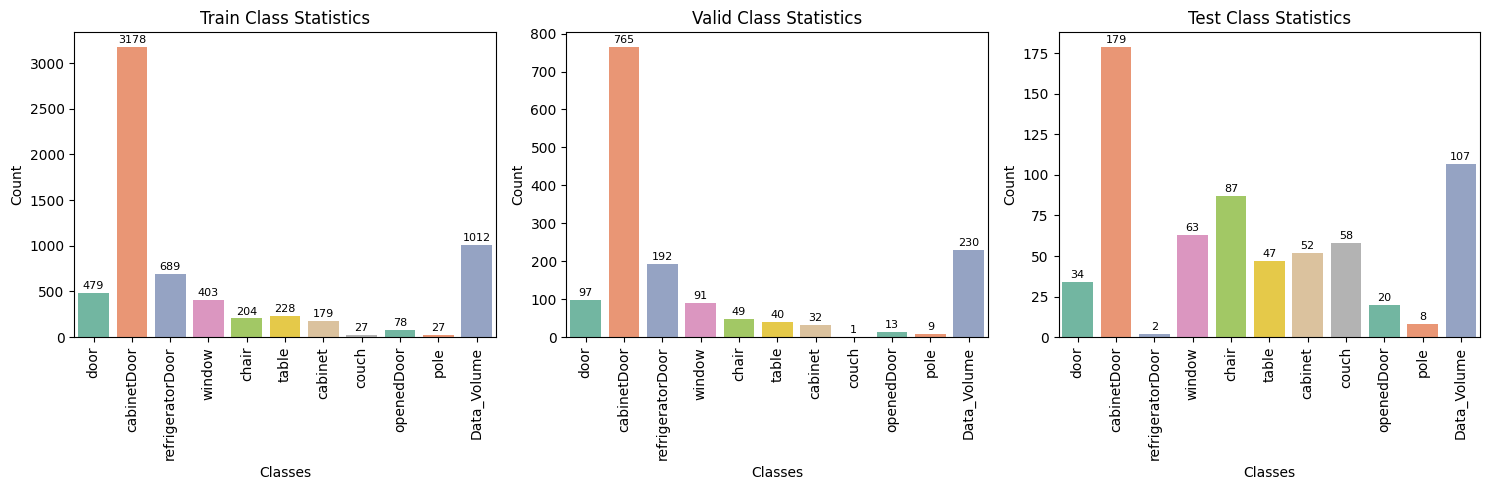

In [168]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()


In [169]:
yaml_path = Path("/content/indoor-object-detection/indoor.yaml")
cfg = yaml.safe_load(yaml_path.read_text())

root = Path(cfg["path"])
print("YAML root:", root, "exists:", root.exists())

for k in ["train", "val", "test"]:
    p = root / cfg[k]
    print(k, p, "exists:", p.exists())

YAML root: /content/indoor-object-detection exists: True
train /content/indoor-object-detection/train/images exists: True
val /content/indoor-object-detection/valid/images exists: True
test /content/indoor-object-detection/test/images exists: True


In [170]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: Tesla T4


In [171]:
model = YOLO(Indoor.BASE_MODEL_WEIGHTS)
print("Model loaded:", Indoor.BASE_MODEL_WEIGHTS)

Model loaded: yolov9m.pt


In [172]:
%%time
def train_indoor(model_weights: str,
                 data_yaml: str,
                 epochs: int,
                 batch: int,
                 imgsz: int = 768,
                 project: str = "runs/indoor",
                 name: str = "exp",
                 optimizer: str = "auto",
                 patience: int = 20,
                 use_gpu: bool = True):

    # 1) device
    if use_gpu and torch.cuda.is_available():
        device = 0
        print("✅ Using GPU:", torch.cuda.get_device_name(0))
    else:
        device = "cpu"
        print("⚠️ Using CPU")

    # 2) load model
    model = YOLO(model_weights)
    print("Model loaded:", model_weights)
    print("Data yaml:", data_yaml)

    # 3) train
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        batch=batch,
        imgsz=imgsz,
        device=device,
        project=project,
        name=name,
        optimizer=optimizer,
        patience=patience,

        # augmentation (помірно)
        mosaic=1.0,
        mixup=0.1,
        fliplr=0.5,
        scale=0.5,
        translate=0.1,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
    )

    # 4) where outputs are
    run_dir = Path(project) / name
    print("\n📁 Run directory:", run_dir.resolve())
    print("Best weights:", (run_dir / "weights" / "best.pt"))
    print("Last weights:", (run_dir / "weights" / "last.pt"))
    print("Curves image:", (run_dir / "results.png"))
    print("CSV logs:", (run_dir / "results.csv"))
    print("Confusion matrix:", (run_dir / "confusion_matrix.png"))

    return results, run_dir


aug_name = Indoor.EXP_NAME + "_8m"

results, run_dir = train_indoor(
    model_weights=Indoor.BASE_MODEL_WEIGHTS,
    data_yaml=Indoor.DATA_YAML,
    epochs=Indoor.EPOCHS,
    batch=Indoor.BATCH_SIZE,
    imgsz=768,
    project="runs/indoor",
    name=aug_name,                 
    optimizer=Indoor.OPTIMIZER,
    patience=Indoor.PATIENCE,
    use_gpu=True,
)

✅ Using GPU: Tesla T4


Model loaded: yolov9m.pt
Data yaml: /content/indoor-object-detection/indoor.yaml
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/indoor-object-detection/indoor.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov9m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=indoor_yolov9m_30e_8m, nbs=64, nms=False, ops

In [173]:
df = pd.read_csv("runs/indoor/indoor_yolov9s_10e/results.csv")
df.tail()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
5      6  239.489         1.45526         1.75074         1.47167   
6      7  278.226         1.44853         1.62013         1.46259   
7      8  317.102         1.38435         1.45550         1.42189   
8      9  355.592         1.34875         1.33085         1.38521   
9     10  394.608         1.32377         1.24695         1.36094   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
5               0.51033            0.31602           0.29723   
6               0.51254            0.31979           0.32191   
7               0.50387            0.34331           0.33873   
8               0.59864            0.33029           0.37498   
9               0.40846            0.43383           0.38551   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
5              0.17524       1.45974       1.48275       1.50415  0.000361   
6              0.19377       1.39764       1.39425       1.46218  0.000290   
7              0.20346       1.36845       1.36088       1.43215  0.000219   
8              0.23071       1.35171       1.26153       1.42411  0.000149   
9              0.23796       1.34898       1.22511       1.42037  0.000078   

     lr/pg1    lr/pg2  
5  0.000361  0.000361  
6  0.000290  0.000290  
7  0.000219  0.000219  
8  0.000149  0.000149  
9  0.000078  0.000078

In [174]:
df = pd.read_csv("runs/indoor/indoor_yolov9s_20e/results.csv")
df.tail()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
15     16  636.259         1.28277         1.12356         1.34606   
16     17  675.413         1.23704         1.02360         1.31852   
17     18  714.039         1.21134         0.97123         1.30840   
18     19  752.861         1.18927         0.94204         1.28602   
19     20  791.601         1.16986         0.92273         1.26812   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
15               0.37693            0.44008           0.38089   
16               0.50053            0.34884           0.38716   
17               0.38380            0.41126           0.39653   
18               0.47237            0.51442           0.48730   
19               0.56858            0.36987           0.41606   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
15              0.23462       1.34696       1.20546       1.45190  0.000184   
16              0.24108       1.35496       1.13559       1.44799  0.000149   
17              0.24360       1.36033       1.14408       1.45612  0.000113   
18              0.27797       1.34771       1.14957       1.44461  0.000078   
19              0.25451       1.33722       1.14238       1.43589  0.000042   

      lr/pg1    lr/pg2  
15  0.000184  0.000184  
16  0.000149  0.000149  
17  0.000113  0.000113  
18  0.000078  0.000078  
19  0.000042  0.000042

In [175]:
df = pd.read_csv("runs/indoor/indoor_yolov9s_20e_aug/results.csv")
df.tail()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
15     16  647.474         1.27406         1.17477         1.35186   
16     17  686.826         1.24347         1.05408         1.33597   
17     18  726.293         1.22122         0.99455         1.31934   
18     19  764.696         1.18726         0.95950         1.30118   
19     20  803.489         1.17206         0.93361         1.29023   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
15               0.49436            0.37353           0.40954   
16               0.56591            0.35994           0.39017   
17               0.48914            0.38165           0.40689   
18               0.46356            0.48672           0.42961   
19               0.43092            0.51907           0.43154   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
15              0.24426       1.36811       1.25172       1.47563  0.000184   
16              0.24228       1.33493       1.17832       1.45031  0.000149   
17              0.25456       1.33406       1.18811       1.45603  0.000113   
18              0.26634       1.33996       1.16426       1.45859  0.000078   
19              0.26881       1.32542       1.15408       1.44989  0.000042   

      lr/pg1    lr/pg2  
15  0.000184  0.000184  
16  0.000149  0.000149  
17  0.000113  0.000113  
18  0.000078  0.000078  
19  0.000042  0.000042

In [176]:
df = pd.read_csv("runs/indoor/indoor_yolov9m_20e_8m/results.csv")
df.tail()

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
15     16   815.958         1.29565         1.23904         1.36399   
16     17   870.048         1.24972         1.10612         1.33182   
17     18   924.598         1.23145         1.03038         1.31708   
18     19   974.587         1.19408         0.99311         1.28869   
19     20  1024.470         1.16865         0.95514         1.27743   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
15               0.59465            0.34913           0.38974   
16               0.61948            0.35048           0.40356   
17               0.45199            0.48153           0.40940   
18               0.45087            0.52008           0.41797   
19               0.60786            0.38159           0.41204   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
15              0.23121       1.38269       1.25722       1.48762  0.000184   
16              0.24935       1.35480       1.15267       1.45093  0.000149   
17              0.26139       1.38486       1.18275       1.47622  0.000113   
18              0.26106       1.35425       1.16352       1.46122  0.000078   
19              0.25829       1.35009       1.16871       1.45855  0.000042   

      lr/pg1    lr/pg2  
15  0.000184  0.000184  
16  0.000149  0.000149  
17  0.000113  0.000113  
18  0.000078  0.000078  
19  0.000042  0.000042

In [177]:
df = pd.read_csv("runs/indoor/indoor_yolov9m_30e_8m/results.csv")
df.tail()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
25     26  1828.63         1.15417         0.91606         1.30963   
26     27  1900.43         1.13186         0.86390         1.30412   
27     28  1974.21         1.11430         0.83081         1.28858   
28     29  2048.12         1.09269         0.81447         1.27454   
29     30  2121.62         1.08061         0.77221         1.26676   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
25               0.36566            0.44679           0.40851   
26               0.37217            0.47205           0.41602   
27               0.40350            0.46347           0.42130   
28               0.53837            0.46527           0.42792   
29               0.41304            0.46227           0.43969   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
25              0.24633       1.34675       1.21125       1.52043  0.000125   
26              0.25125       1.37830       1.22298       1.53904  0.000101   
27              0.25481       1.37895       1.21065       1.53543  0.000078   
28              0.25721       1.38001       1.21176       1.53425  0.000054   
29              0.26042       1.37332       1.17148       1.52972  0.000031   

      lr/pg1    lr/pg2  
25  0.000125  0.000125  
26  0.000101  0.000101  
27  0.000078  0.000078  
28  0.000054  0.000054  
29  0.000031  0.000031

In [178]:
run_dir = Path("runs/indoor") / aug_name
df = pd.read_csv(run_dir / "results.csv")

last = df.iloc[-1]
best_map50 = df["metrics/mAP50(B)"].max()
best_map5095 = df["metrics/mAP50-95(B)"].max()

print("Last epoch metrics:")
print("  Precision:", float(last["metrics/precision(B)"]))
print("  Recall   :", float(last["metrics/recall(B)"]))
print("  mAP50    :", float(last["metrics/mAP50(B)"]))
print("  mAP50-95 :", float(last["metrics/mAP50-95(B)"]))

print("\nBest over training:")
print("  Best mAP50   :", float(best_map50))
print("  Best mAP50-95:", float(best_map5095))

Last epoch metrics:
  Precision: 0.41304
  Recall   : 0.46227
  mAP50    : 0.43969
  mAP50-95 : 0.26042

Best over training:
  Best mAP50   : 0.43969
  Best mAP50-95: 0.26042


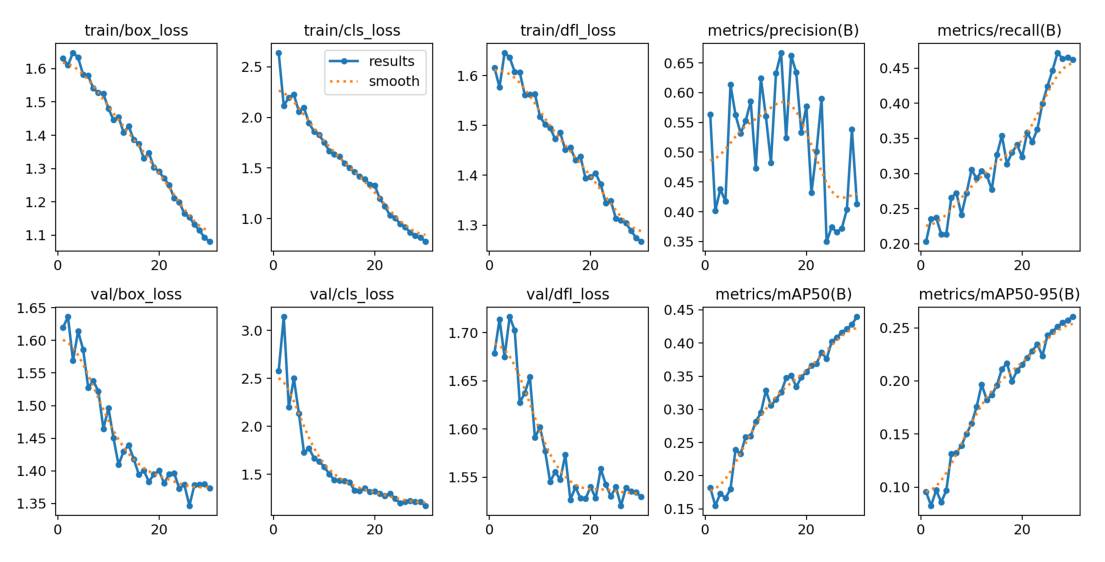

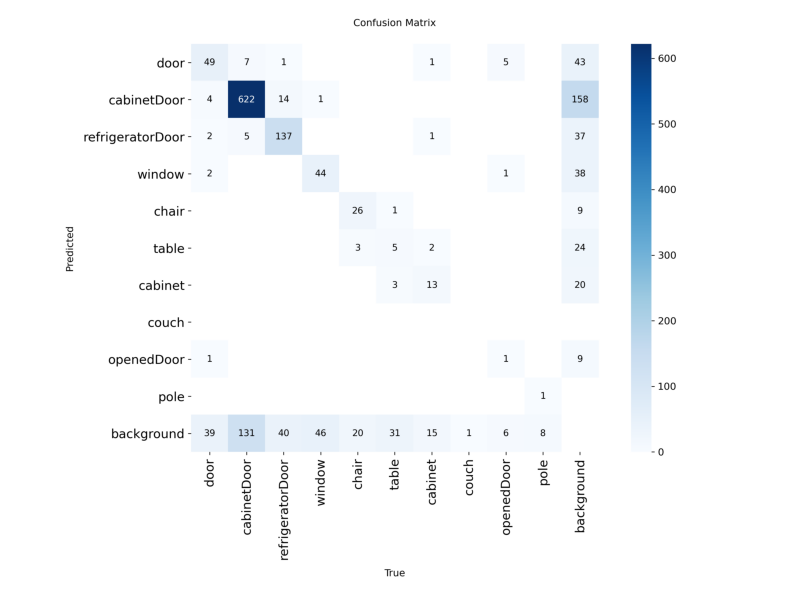

In [179]:
def show_image(path, figsize=(12,8)):
    img = Image.open(path)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

show_image(run_dir / "results.png", figsize=(14,9))
show_image(run_dir / "confusion_matrix.png", figsize=(10,10))

У ході експериментів із моделями YOLOv9s та YOLOv9m було встановлено, що збільшення розміру моделі та роздільної здатності зображень (до 768) дозволяє дещо покращити показники mAP50 та mAP50-95, однак приріст є помірним через дисбаланс класів і складність сцени. Найкращий результат було досягнуто для моделі YOLOv9m, яка продемонструвала mAP50 = 0.439 та стабільну динаміку навчання без явного перенавчання.

Для подальшого покращення якості детекції доцільно зосередитися на балансуванні датасету (зокрема через цілеспрямовану аугментацію рідкісних класів), збільшенні кількості епох із ранньою зупинкою, а також експериментах з оптимізатором і параметрами аугментації. Поставленої навчальної мети - коректно навчити модель та проаналізувати її поведінку - досягнуто.

У першому експерименті з YOLOv9m та 10 епохами модель лише почала вивчати дані: втрати зменшувалися, але значення mAP були низькими, що свідчило про недонавчання. Збільшення кількості епох до 20 (YOLOv9m) дало помітне покращення mAP50 і стабілізувало криві навчання, однак recall залишався відносно невисоким через дисбаланс класів.

Додавання аугментації при 20 епохах дозволило трохи підвищити узагальнюючу здатність моделі та зменшити перенавчання, хоча приріст метрик був помірним. Експерименти з YOLOv9s (20 епох) показали гірші результати порівняно з v9m, що вказує на недостатню ємність меншої моделі для цього датасету.

Фінальний експеримент із YOLOv9m, 30 епохами та збільшеним розміром зображень (768) продемонстрував найкращий баланс між mAP50 та mAP50-95, хоча precision знизився через більшу кількість хибнопозитивних спрацювань. Загалом результати підтвердили, що для даного набору даних більш потужна модель та довше навчання є ефективнішими, ніж проста зміна архітектури без роботи з даними.